# STM Transit Delay Data Modeling

This notebook explores three tree-based regression models in order to find the one that predicts the delay with the best accuracy.

## Imports

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer, mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import cross_validate, train_test_split, GridSearchCV, RandomizedSearchCV
from xgboost import XGBRegressor

In [17]:
df = pd.read_csv('../data/preprocessed.csv')

## Split the data

In [18]:
# Separate the features from the target variable
X = df.drop('delay', axis=1)
y = df['delay']

In [19]:
# Train-validation-test split (70-15-15) 
# Use 70% for training because the dataset is large
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

Since only tree-based regression models are explored in this project, scaling is not needed because the models are not sensitive to the absolute scale or distribution of the features.

## Base Model: Random Forest Regression

### Fit Model

In [20]:
base_model = RandomForestRegressor(n_estimators=5, random_state=42)
base_model.fit(X_train, y_train)

RandomForestRegressor(n_estimators=5, random_state=42)

In [21]:
y_pred = base_model.predict(X_val)

### Evaluate Model

#### Metrics

In [22]:
mae = mean_absolute_error(y_val, y_pred)
mse = mean_squared_error(y_val, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_val, y_pred)

In [23]:
print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.4f}")

MAE: 57.63
MSE: 13794.67
RMSE: 117.45
R²: 0.4780


**MAE**<br>
On average, the predictions are off by one minute, which seems reasonable.

**RMSE**<br>
The typical error being about 2 minutes seems pretty good.

**R²**<br>
The model explains 48% of the variance in the actual delays, which is not too bad, considering how noisy and random transit delays can be (weather, mechanical issues, accidents, etc.)

#### Residual Analysis

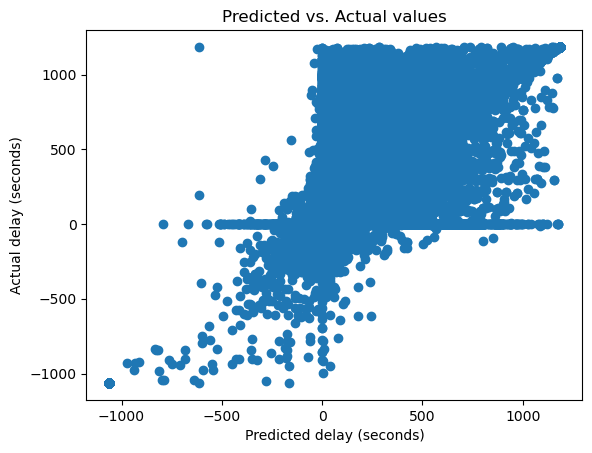

In [24]:
# Plot predicted vs. actual values
plt.scatter(x=y_pred, y=y_val)
plt.title('Predicted vs. Actual values')
plt.xlabel('Predicted delay (seconds)')
plt.ylabel('Actual delay (seconds)')
plt.savefig('../images/actual_vs_predict_base.png', bbox_inches='tight')
plt.show()

Interpret plot

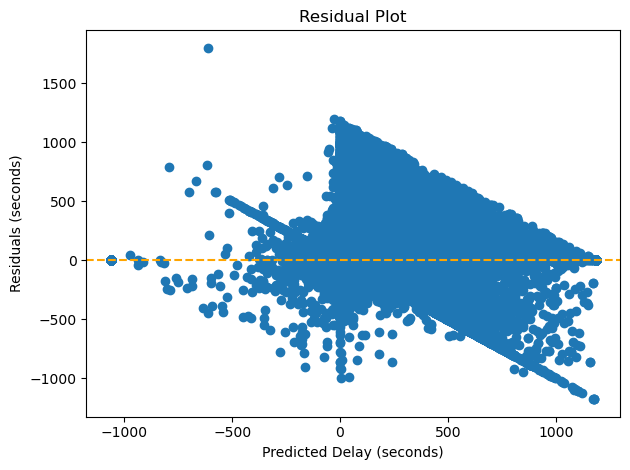

In [25]:
# Plot residuals
residuals = y_val - y_pred
    
plt.scatter(x=y_pred, y=residuals)
plt.title('Residual Plot')
plt.xlabel('Predicted Delay (seconds)')
plt.ylabel('Residuals (seconds)')
plt.axhline(0, linestyle='--', color='orange')
plt.tight_layout()
plt.savefig('../images/residual_plot_base.png', bbox_inches='tight')
plt.show()

Interpret plot

#### K-Fold Cross Validation

In [26]:
scoring = {
    'MAE': make_scorer(mean_absolute_error, greater_is_better=False),
    'MSE': make_scorer(mean_squared_error, greater_is_better=False),
    'R²': make_scorer(r2_score)
}

scores = cross_validate(
  base_model,
  X_train,
  y_train,
  scoring=scoring,
  cv=5,
  n_jobs=-1)

scores_df = pd.DataFrame(scores)

In [27]:
scores_df

,fit_time,score_time,test_MAE,test_MSE,test_R²
0,321.586831,1.868034,-57.666879,-13838.869777,0.488743
1,313.720936,2.450084,-57.715145,-13763.474702,0.471583
2,324.217708,1.068519,-57.526720,-13743.540143,0.482852
3,321.616808,1.857158,-57.370814,-13598.623387,0.487106
4,319.488090,2.166383,-57.700935,-13851.743592,0.486321


In [28]:
print(f'Mean MAE: {-scores_df['test_MAE'].mean()}')
print(f'Mean MSE: {-scores_df['test_MSE'].mean()}')
print(f'Mean RMSE: {np.sqrt(-scores_df['test_MSE']).mean()}')
print(f'Mean R²: {scores_df['test_R²'].mean()}')

Mean MAE: 57.596098643290325
Mean MSE: 13759.250320032597
Mean RMSE: 117.29919477146942
Mean R²: 0.4833209585717282


### Hyperparameter tuning

In [34]:
# Run a RandomizedSearchi instead of a GridSearch because of the large volume of data
param_dist = {
    'n_estimators': [10, 20, 50, 100],
    'max_depth': [10, 20, 30, 40, None],
    'min_samples_split': [2, 5, 10, 15],
    'max_features': ['sqrt', 'log2', None]
}

search_model = RandomizedSearchCV(
  estimator=RandomForestRegressor(),
  param_distributions=param_dist,
  scoring=scoring,
  refit='MSE',
  n_iter=10,
  cv=None,
  random_state=42)

search_model.fit(X_train, y_train)

KeyboardInterrupt: 

In [117]:
search_model.best_estimator_

RandomForestRegressor(max_depth=20, max_features=None, min_samples_split=5,
                      n_estimators=15)

In [122]:
pd.DataFrame(search_model.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_min_samples_split,param_max_features,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,10.695220,0.313359,0.912510,0.035463,5,2,log2,None,"{'n_estimators': 5, 'min_samples_split': 2, 'm...",0.978316,0.957887,0.959407,0.965203,0.009293,5
1,25.614579,1.068302,2.090904,0.289412,10,10,sqrt,50,"{'n_estimators': 10, 'min_samples_split': 10, ...",0.976860,0.973928,0.976089,0.975625,0.001241,4
2,141.771835,4.869043,0.680985,0.012289,15,5,None,20,"{'n_estimators': 15, 'min_samples_split': 5, '...",0.999548,0.976991,0.999717,0.992085,0.010674,1
3,88.739744,7.466406,0.524681,0.076916,10,5,None,20,"{'n_estimators': 10, 'min_samples_split': 5, '...",0.999728,0.977055,0.999338,0.992041,0.010597,2
4,157.789525,19.295730,0.946021,0.126604,15,10,None,50,"{'n_estimators': 15, 'min_samples_split': 10, ...",0.998441,0.976896,0.998544,0.991293,0.010181,3


In [ ]:
# Calculate metrics

In [ ]:
# Run Cross Validation

### Feature importances

In [29]:
importances = base_model.feature_importances_
std = np.std([tree.feature_importances_ for tree in base_model.estimators_], axis=0)

In [ ]:
# Sort predictors
forest_importances = pd.Series(importances, index=X.columns)
forest_importances.sort_values(ascending=False)

historical_avg_delay    0.282067
delay_was_clipped       0.244903
trip_progress_pct       0.101017
stop_sequence           0.086540
pca_coords              0.049333
stop_id                 0.043766
route_id                0.042393
windspeed               0.024494
temperature             0.023330
sch_hour_sin            0.022138
dtype: float64

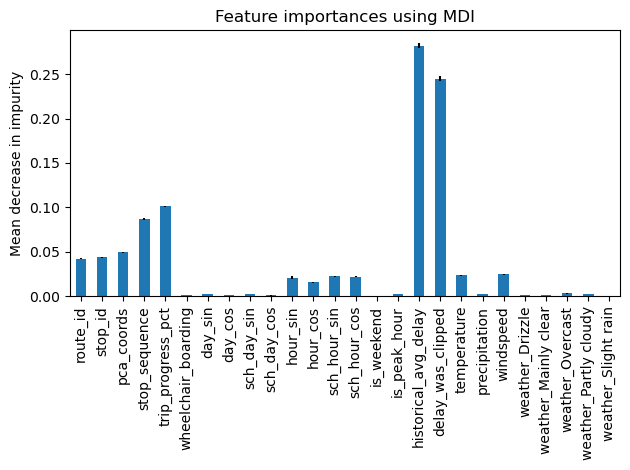

In [32]:
# Plot the impurity-based importance (MDI)
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title('Feature importances using MDI')
ax.set_ylabel('Mean decrease in impurity')
fig.tight_layout()
plt.savefig('../images/mdi_base.png', bbox_inches='tight')
plt.show()

Interpret plot

## Model ensembling: Random Forest + Gradient Boosting

## XGBoost

## Final Model

### Evaluation

### Make Prediction

## End